# Run Analysis

This notebook analyze the information generated by the experiments.

In this run, the search grid for the threshold values is finer than run **28-06-2022--22-13-20**. I wanted to see whether this helps the transformation in beating the untransformed agents. Unfortunately, we cannot see that from the results of this run.

I do notice that the confidence interval of the ranking seems to be closer to each other among the agents. I wonder whether this is purely the effect of having less agent in this run (we had 6 in this run, 8 in the previous run), or a sign of more delicate threshold values are indeed important for the transformation to do its job well.

Another thing I have in this analysis is the final part: MLP has the choice of switching to a linear model. In that section, I discussed briefly about this flexible setting MLP has, and what can we say about the tranformation from it. I'd say the attempt is good, but I'm not sure that I have reached impactful and meaningful conclusions there.

Other than those, there is nothing new. ETS continued to beat others. And the transformation only seem to make the models worse.

In [8]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from pprint import pprint

plt.rcParams['figure.figsize'] = (20, 8)
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Load run information

In [3]:
plt.style.use('ggplot')

In [4]:
experiment = '30-06-2022--19-41-17'
with open(f'experiment_info/{experiment}/run_info.json', 'r') as file:
    run_info = json.load(file)

pprint(run_info)

{'Avg. len of series': 137.14761904761906,
 'config input': {'dataset': {'cumulate used': 210,
                              'file name': 'm3_monthly_dataset.json',
                              'file path': 'datasets/',
                              'file type': 'json',
                              'max length': 9999,
                              'min length': 130,
                              'use series': 210},
                  'execution config': {'n of workers': 20},
                  'modelling config': {'forecast horizon': 1,
                                       'score measure': 'SMAPE',
                                       'test size': 15,
                                       'validation size': 10},
                  'models': ['EN', 'MLP', 'ETS'],
                  'transformation config': {'xthresholds': [0.01, 1.1, 0.1]},
                  'type of run': 'real run'},
 'messages': {},
 'model hyper_params': {'EN': {'alpha': [0.1, 1, 10, 100],
                       

Load agents' run information

In [5]:
agent_infos = {}
run = run_info['run time'][0]
models = run_info['config input']['models']

for m in models:

    agent_1 = f'{m}_raw'
    agent_2 = f'{m}_tran'

    with open(f'experiment_info/{run}/{agent_1}.json', 'r') as file:
        agent_infos[agent_1] = json.load(file)
    with open(f'experiment_info/{run}/{agent_2}.json', 'r') as file:
        agent_infos[agent_2] = json.load(file)


Check if all time series have been played successfully. Exclude those which not all agents have played successfully.

In [6]:
series_ran = list(agent_infos[agent_1].keys())
n_series_ran = len(series_ran)
agent_fails = {k: [] for k in agent_infos.keys()}
series_excluded = []

for agent, plays in agent_infos.items():
    for series, info in plays.items():
        if info['message'] != None:
            agent_fails[agent].append(series)
            series_excluded.append(series)

if not series_excluded:
    print('All agents have successfully ran on all series.')
else:
    print(series_excluded)
    print(agent_fails)

All agents have successfully ran on all series.


## Visualisation of experiment results

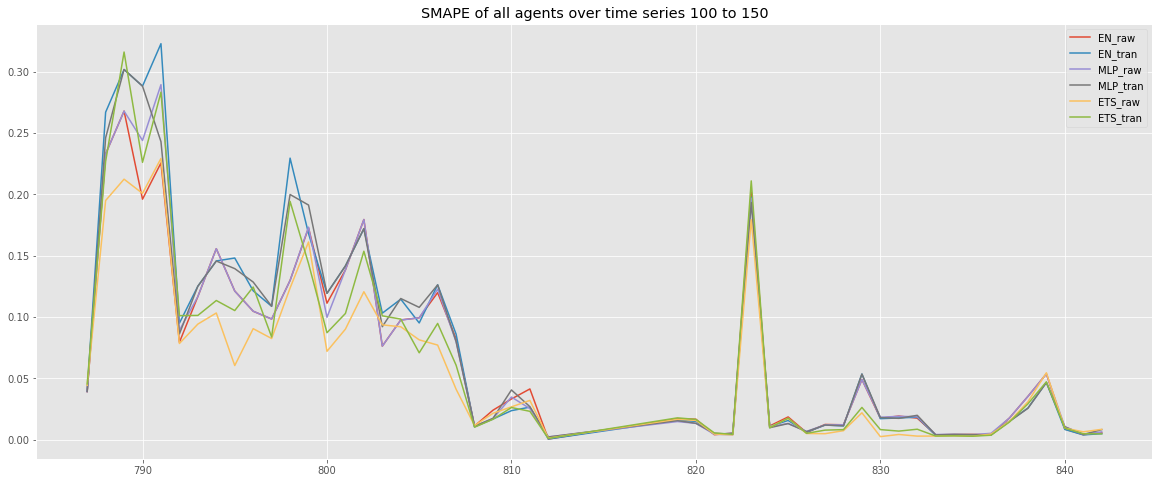

In [9]:
segment_start: int = 100
segment_end: int = 150

for agent, plays in agent_infos.items():
    plt.plot(
        np.array(series_ran[segment_start:segment_end]).astype(float),
        [play['test SMAPE'] for play in list(plays.values())[segment_start:segment_end]],
        label=f'{agent}'
    )

plt.title(f'SMAPE of all agents over time series {segment_start} to {segment_end}')
plt.legend()
plt.show()

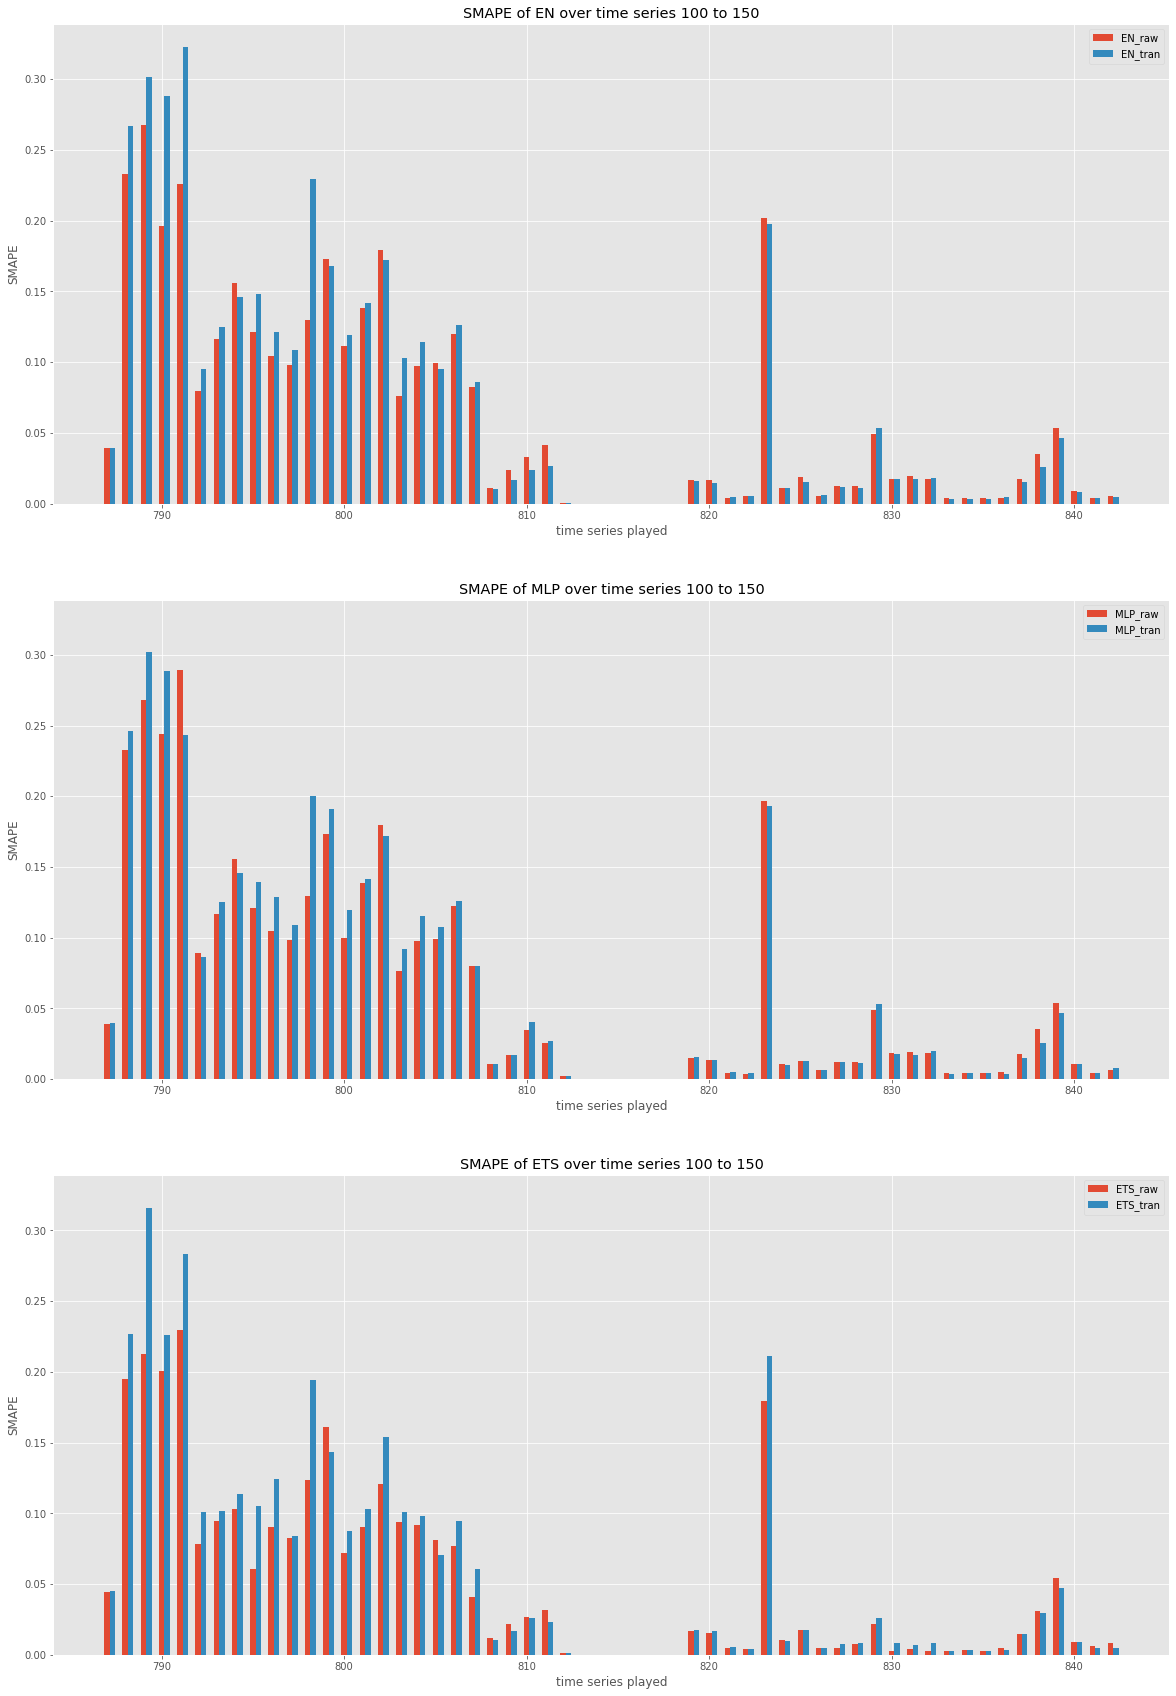

In [10]:
segment_start: int = 100
segment_end: int = 150
n_models = len(models)

fig, axs = plt.subplots(n_models, 1, sharey=True, figsize = (20, 30))
for i, m in enumerate(models):

    agent_1 = f'{m}_raw'
    agent_2 = f'{m}_tran'
    axs[i].bar(
        np.array(series_ran[segment_start:segment_end]).astype(float),
        [
            play['test SMAPE'] for play in list(agent_infos[agent_1].values())[segment_start:segment_end]
        ],
        width=0.3,
        label=agent_1
    )
    axs[i].bar(
        np.array(series_ran[segment_start:segment_end]).astype(float) + 0.3,
        [
            play['test SMAPE'] for play in list(agent_infos[agent_2].values())[segment_start:segment_end]
        ],
        width=0.3,
        label=agent_2
    )
    axs[i].legend()
    axs[i].set_title(f'SMAPE of {m} over time series {segment_start} to {segment_end}')
    axs[i].set_xlabel('time series played')
    axs[i].set_ylabel('SMAPE')

plt.show()

### Ranking of the agents

In this section, we compute the ranking of each agent per time series. So each agent will have a ranking for a time series, ranging from 1 to the number of agent involved. I store this ranking info to the `agent_infos` dictionary, as how SMAPE is stored for each agent per time series.

In [11]:
for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        score = play_info['test SMAPE']
        lower = [1 for a in agent_infos.keys() if agent_infos[a][series]['test SMAPE']-score < 0]
        play_info['ranking'] = sum(lower) + 1

In [12]:
ss = [5, 3, 7, 1, 10, 5]  # five scores
target = 5                # the lower the better, rank of target

lower = [1 for s in ss if s-target < 0]
rank = sum(lower) + 1
print(lower, rank)

[1, 1] 3


In [16]:
pprint(agent_infos['ETS_raw']['822'])
pprint(agent_infos['MLP_tran']['822'])

{'best model': {'damped trend': True,
                'seasonal': 'add',
                'seasonal periods': 12,
                'trend': 'add'},
 'message': None,
 'ranking': 1,
 'test SMAPE': 0.003923,
 'val SMAPE': 0.002152,
 'y hats': [5559.523619528829,
            5648.889575107336,
            5643.23886606587,
            5629.437687101704,
            5637.763180045242,
            5644.99603928777,
            5606.211767410757,
            5659.516175310511,
            5689.728685285737,
            5719.774087619531,
            5766.3136812414195,
            5813.584135727326,
            5881.4894513039835,
            5967.4614146961985,
            6003.62194241058]}
{'best model': {'max iter': 500,
                'n lag': 5,
                'struc': [0],
                'thres down': 0.01,
                'thres up': 0.21},
 'message': None,
 'ranking': 4,
 'test SMAPE': 0.004422,
 'val SMAPE': 0.002267,
 'y hats': [5550.7785120395865,
            5680.823432399534,

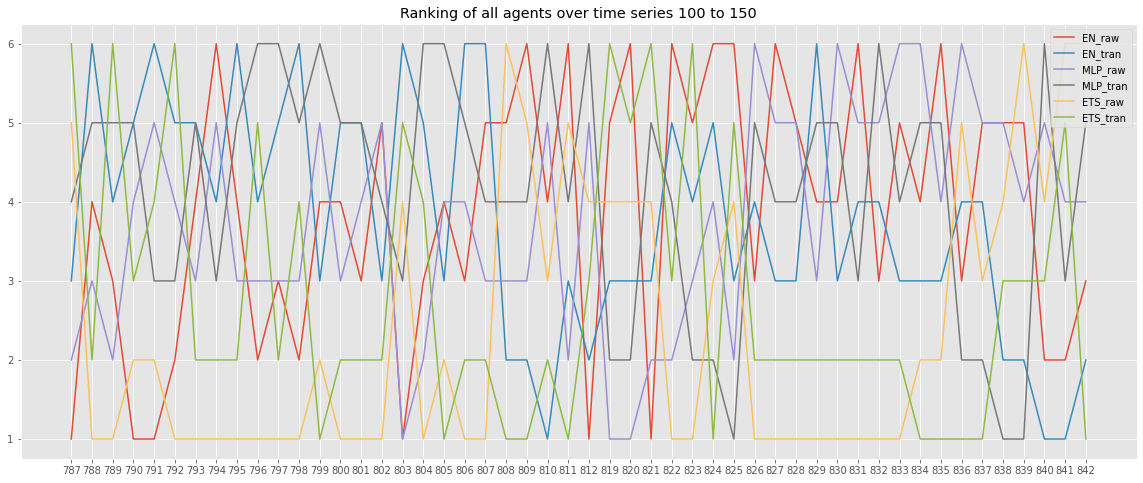

In [17]:
segment_start: int = 100
segment_end: int = 150

for agent, plays in agent_infos.items():
    plt.plot(series_ran[segment_start:segment_end], [play['ranking'] for play in list(plays.values())[segment_start:segment_end]], label=f'{agent}')

plt.title(f'Ranking of all agents over time series {segment_start} to {segment_end}')
plt.legend()
plt.show()

In [63]:
np.array(series_ran[segment_start:segment_end]).astype(float) + 0.1

array([575.1, 576.1, 577.1, 578.1, 579.1, 580.1, 581.1, 582.1, 583.1,
       584.1, 585.1, 586.1, 587.1, 588.1, 589.1, 590.1, 591.1, 592.1,
       593.1, 594.1, 595.1, 596.1, 597.1, 598.1, 599.1, 600.1, 601.1,
       602.1, 603.1, 604.1, 605.1, 606.1, 607.1, 608.1, 610.1, 611.1,
       612.1, 613.1, 614.1, 615.1, 616.1, 617.1, 618.1, 619.1, 620.1,
       621.1, 622.1, 623.1, 624.1, 625.1])

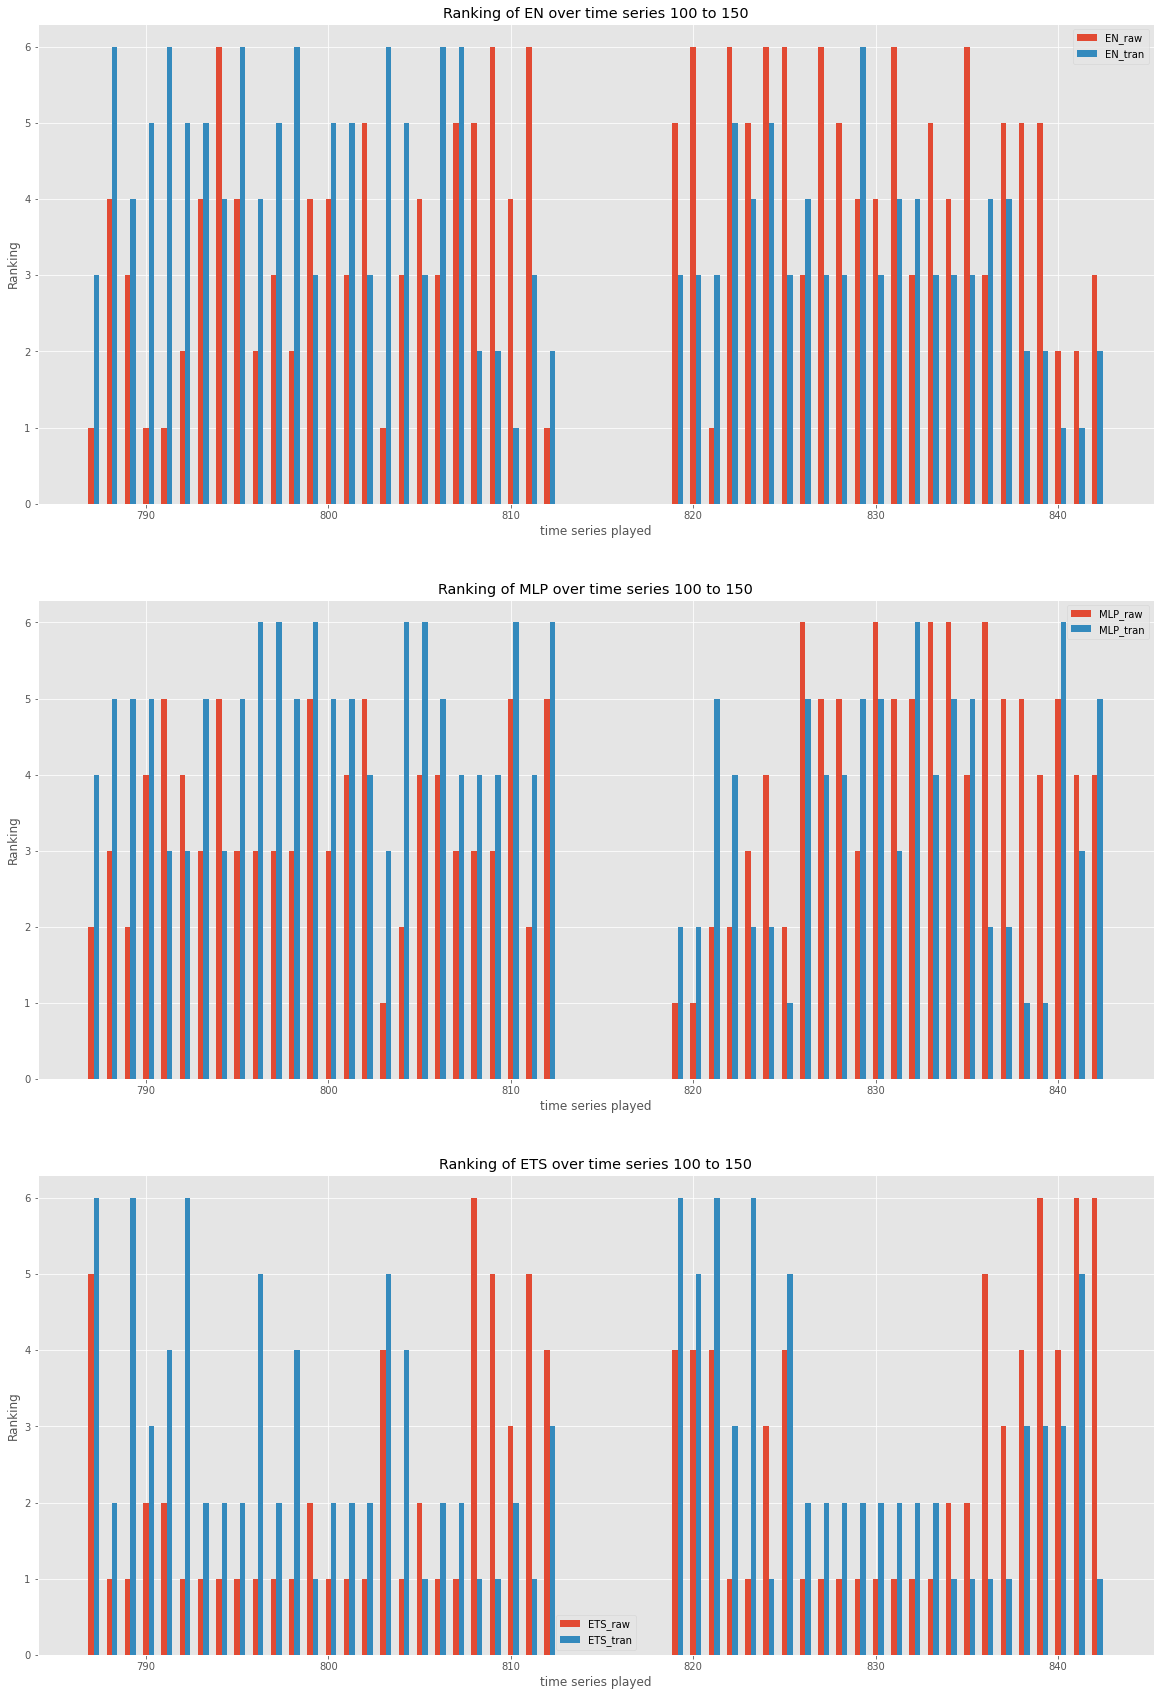

In [18]:
segment_start: int = 100
segment_end: int = 150
n_models = len(models)

fig, axs = plt.subplots(n_models, 1, sharey=True, figsize = (20, 30))
for i, m in enumerate(models):
    
    agent_1 = f'{m}_raw'
    agent_2 = f'{m}_tran'
    axs[i].bar(
        np.array(series_ran[segment_start:segment_end]).astype(float),
        [
            play['ranking'] for play in list(agent_infos[agent_1].values())[segment_start:segment_end]
        ],
        width=0.3,
        label=agent_1
    )
    axs[i].bar(
        np.array(series_ran[segment_start:segment_end]).astype(float) + 0.3,
        [
            play['ranking'] for play in list(agent_infos[agent_2].values())[segment_start:segment_end]
        ],
        width=0.3,
        label=agent_2
    )
    axs[i].legend()
    axs[i].set_title(f'Ranking of {m} over time series {segment_start} to {segment_end}')
    axs[i].set_xlabel('time series played')
    axs[i].set_ylabel('Ranking')

plt.show()

## Statistics of overall performance

In this section, we calculate some statistics that concludes the general performance of each agent over the time series played.

In [19]:
numbers = {
    agent: {
        'SMAPEs': [],
        'rankings': []
    } for agent in agent_infos
}

stats = {
    agent: {
        'mean SMAPE': None,
        'std. SMAPE': None,
        'mean ranking': None,
        'std. ranking': None
    } for agent in agent_infos
}

for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        numbers[agent]['SMAPEs'].append(play_info['test SMAPE'])
        numbers[agent]['rankings'].append(play_info['ranking'])
    
    stats[agent]['mean SMAPE'] = np.mean(numbers[agent]['SMAPEs'])
    stats[agent]['std. SMAPE'] = np.std(numbers[agent]['SMAPEs'])
    stats[agent]['mean ranking'] = np.mean(numbers[agent]['rankings'])
    stats[agent]['std. ranking'] = np.std(numbers[agent]['rankings'])

In this section, we compute the alpha-confidence interval of the rankings for the agents.

In [20]:
alpha = 0.1
Q = len(list(agent_infos.keys()))
P = len(series_ran)
dist = np.random.standard_normal(size=Q)
r_lower, r_upper = np.min(dist), np.max(dist)
qrange = list(np.arange(r_lower, r_upper, step=(r_upper-r_lower)/100))
q_alpha_Q = qrange[-int(alpha*100)]

def conf_limit(Q, P, mean_R, q_alpha_Q):
    stat = 0.5 * q_alpha_Q * np.sqrt(Q*(Q+1)/(12 * P))
    return round(mean_R-stat, 6), round(mean_R+stat, 6)

for agent in agent_infos.keys():
    stats[agent][f'{100-int(alpha*100)}% ranking confi. limits'] = conf_limit(Q, P, stats[agent]['mean ranking'], q_alpha_Q)

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,MLP_raw,MLP_tran,ETS_raw,ETS_tran
mean SMAPE,0.08161,0.086998,0.081933,0.087139,0.069306,0.07509
std. SMAPE,0.105466,0.11282,0.110199,0.118077,0.097772,0.103233
mean ranking,3.466667,3.819048,3.42381,3.838095,2.942857,3.285714
std. ranking,1.627541,1.532387,1.449599,1.653993,1.918971,1.76589
90% ranking confi. limits,"(3.335235, 3.598098)","(3.687616, 3.950479)","(3.292378, 3.555241)","(3.706664, 3.969527)","(2.811426, 3.074289)","(3.154283, 3.417146)"


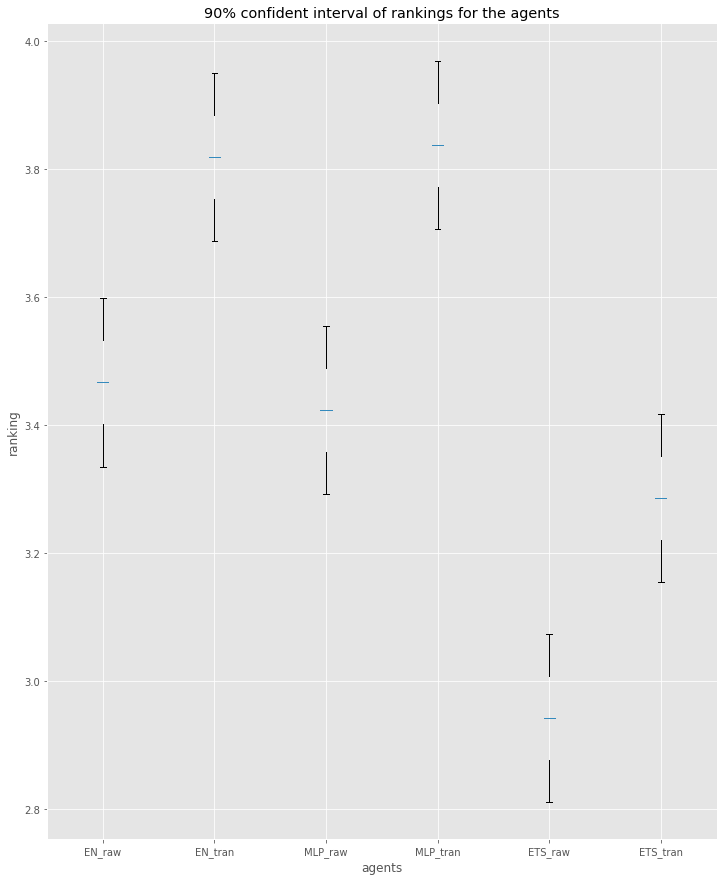

In [21]:
plt.figure(figsize=(12, 15))
plt.boxplot(
    [[agent[f'{100-int(alpha*100)}% ranking confi. limits'][0], agent['mean ranking'], agent[f'{100-int(alpha*100)}% ranking confi. limits'][1]] for agent in stats.values()],
    showbox=False,
    labels=list(numbers.keys()),
    widths=0.1)
plt.title(f'{100-int(alpha*100)}% confident interval of rankings for the agents')
plt.xlabel('agents')
plt.ylabel('ranking')
plt.show()

In this section, we compute another performance measure, called the fraction-best measure. Building on our basis performance measure SMAPE, we compute how much of a fraction out of all played time series that a model beats all other models. This measure lets us know the potential of an agent being exceptionally good conditional on the given datasets.

In [22]:
for agent, play_info in stats.items():
    play_info['frac best'] = np.sum([1 for r in numbers[agent]['rankings'] if r == 1])/n_series_ran

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,MLP_raw,MLP_tran,ETS_raw,ETS_tran
mean SMAPE,0.08161,0.086998,0.081933,0.087139,0.069306,0.07509
std. SMAPE,0.105466,0.11282,0.110199,0.118077,0.097772,0.103233
mean ranking,3.466667,3.819048,3.42381,3.838095,2.942857,3.285714
std. ranking,1.627541,1.532387,1.449599,1.653993,1.918971,1.76589
90% ranking confi. limits,"(3.335235, 3.598098)","(3.687616, 3.950479)","(3.292378, 3.555241)","(3.706664, 3.969527)","(2.811426, 3.074289)","(3.154283, 3.417146)"
frac best,0.133333,0.1,0.114286,0.119048,0.380952,0.17619


# MLP has the choice of switching to a linear model

MLP converges to simple linear regression when it does not have any hidden layer at all. According to *Balkin and Ord (2000)*, being able to switch to a simple linear model is a boost in performance. In the table above and in the 90/% confidence interval of the ranking graph, you can see that MLP and EN had perform similarly. This invokes the question is it because MLP had decided to switch to a linear model most of the time?

## How often did MLP converge to linear regression?

In this section, I show how often did MLP switch to simple linear regression.

In [23]:
n_series_ran
MLP_raw_lm = []
MLP_tran_lm = []
for s in series_ran:
    if agent_infos['MLP_raw'][s]['best model']['struc'] == [0]:
        MLP_raw_lm.append(s)
    if agent_infos['MLP_tran'][s]['best model']['struc'] == [0]:
        MLP_tran_lm.append(s)

print('MLP raw lm count: ', len(MLP_raw_lm))
print('MLP tran lm count: ', len(MLP_tran_lm))

MLP raw lm count:  89
MLP tran lm count:  66


With a sample size of 210, I'd say the possibility of MLP resorting to a linear model is quit high. In this case, it's not surprising to see MLP performs similarly to EN. Despite this linear setting, they do still have different features: EN has regularisation set-up which MLP does not, and MLP has the choice of resort to a non-linear structure, which both agent had chosen to do more than half of the time.

## How does the transformation impact this choice?


Another interesting question is why does untransformed MLP chose to use a linear model more often than the one with transformation? It's saying that the transformation had made the model decide to use a more complex structure. Although we did not have regularisation settings in MLP that drives the model to go for a simplier structure, does this translate into the transformation is not only an extra work itself, but also tends to make the model more complex? If that's the case, is the tranformation making the task easier for the model?

# Replicate the train to get more information

In the case of some of the information is not explicitly recorded from the experiment, there is a good chance it's implicitly contained in the recorded information. In this section, we derive the implicit information by replicating the traing using the information we have at hand.